In [1]:
%run setup.py

In [2]:
%matplotlib inline

In [3]:
# mw_streams = galstreams.MWStreams(verbose=False)
plot_density_healpy.plot_pretty(figsize=(12,12))

In [4]:
def apwnorm(x, min=None, max=None):
    if min is None:
        min = np.nanmin(x[~np.isinf(x)])
    if max is None:
        max = np.nanmax(x[~np.isinf(x)])
    return np.clip((x - min) / (max - min), 0, 1)

In [5]:
# DES DATA
hpxcube_des, fracdet_des, moduli_des = load_data.load_data(survey='DES_Y6_GOLD', filename='../data/2021/DES_Y6_GOLD_iso_hpxcube_z0.0001_a12.0_gmax23.5_gmin16.fits.gz')

Reading ../data/2021/DES_Y6_GOLD_iso_hpxcube_z0.0001_a12.0_gmax23.5_gmin16.fits.gz...


In [5]:
# FIRE DATA
sim = 'm12i_res7100'
lsr = 0
age = 12
z = 0.0004
hpxcube_fire = np.load('../data/fire_mocks/hpxcube_%s_lsr%i_age%.1f_z%.4f.npy' %(sim, lsr, age, z))
moduli_fire = np.load('../data/fire_mocks/moduli_%s_lsr%i_age%.1f_z%.4f.npy' %(sim, lsr, age, z))
fracdet_fire = np.zeros_like(hpxcube_fire[:,0])
fracdet_fire[hpxcube_fire[:,0] > 1] = 1.0

# # LSR1
# hpxcube_fire1 = np.load('../data/fire_mocks/hpxcube_m12b_res7100_lsr1_v0.npy')
# moduli_fire1 = np.load('../data/fire_mocks/moduli_m12b_res7100_lsr1_v0.npy')
# fracdet_fire1 = np.zeros_like(hpxcube_fire1[:,0])
# fracdet_fire1[hpxcube_fire1[:,0] > 1] = 1.0

# # LSR2
# hpxcube_fire2 = np.load('../data/fire_mocks/hpxcube_m12b_res7100_lsr2_v0.npy')
# moduli_fire2 = np.load('../data/fire_mocks/moduli_m12b_res7100_lsr2_v0.npy')
# fracdet_fire2 = np.zeros_like(hpxcube_fire2[:,0])
# fracdet_fire2[hpxcube_fire2[:,0] > 1] = 1.0

In [22]:
hpxcube = hpxcube_fire
modulus = moduli_fire
fracdet = fracdet_fire
survey = 'FIRE'

In [23]:
reload(streamlib)
reload(load_data)
reload(plot_density_healpy)
def prepare_data(hpxmap, modulus, fracdet, use_bkg=False, printing=False, version=0, gmax=24.7, rerun=True):
    if np.all(fracdet) == None:
        print('No fracdet')
        fracdet = np.zeros_like(hpxcube[:, 0])
        fracdet[np.where(hpxcube[:, 0] > 0)] = 1
        
    ###

#     slices = [(26, 50),
#               (15, 26),
#               (0, 15)]
    slices = [(-1, 0), (0, 1), (1, 2)]

    slice_str = '_'.join(['{}-{}'.format(x, y) for x, y in slices])
    dist = plot_density_healpy.mod2dist(modulus)
    for x, y in slices:
        print(dist[x], dist[y])

    ###

    proj = plot_density_healpy.get_ortho_proj(ends=[[5, -5], [15, -5]], half_sky=False)
    nside = hp.npix2nside(len(hpxcube[:, 0]))
    func = lambda x, y, z: hp.vec2pix(nside, x, y, z)

    ###

    try:
        if rerun:
            alskjf
        data_stack = np.load('../data/data_stack_%s_v%i_g%.1f_bkg%i.npy' % (survey.lower(), version, gmax, use_bkg))
#         data_stack = data_stack.T

    except:
        data_stack = []

        for i in range(np.min(slices), np.max(slices)):
            mu = modulus[i]
            if printing:
                print('%.1f' %mu)

            data_masked = plot_density_healpy.prepare_data(mu, hpxcube, modulus, None, sigma=0.2, fracmin=0.5, clip=100, sgr=True, acs=True, globs_dwarfs=True, lmc=True)
            data = plot_density_healpy.prepare_data(mu, hpxcube, modulus, None, sigma=0.2, fracmin=0.5, clip=100, all_off=True, lmc=False, milky_way=False, sgr=False,
                                                    globulars=False, dwarfs=False, galaxies=False, plane=False, bmax=25, center=False, globs_dwarfs=False, acs=False)
            if use_bkg:
                bkg = plot_density_healpy.fit_bkg(data_masked, proj, sigma=0.2)
                bkg.mask = data.mask
            else:
                bkg = 0
            data_stack.append(data - bkg)

        data_stack = np.asarray(data_stack)

        np.save('../data/data_stack_%s_v%i_g%.1f_bkg%i.npy' % (survey.lower(), version, gmax, use_bkg), data_stack.T)

    ###
    
    if data_stack.shape[1] > data_stack.shape[0]:
        data_stack = data_stack.T

    mask = streamlib.make_mask(nside=512, all_off=True, lmc=False, sgr=False, acs=False, globs_dwarfs=False, dwarfs=False, globulars=False, milky_way=False)
    mask |= fracdet < 1.0
    mask_stack = np.vstack([mask]*data_stack.shape[1]).T

    data_stack_masked = np.ma.array(data_stack, mask=mask_stack)
    data_stack_masked.fill_value = np.nan

    ###

    stacks = [np.sum(data_stack_masked[:, x:y], axis=1) / (y - x) for x, y in slices]
    for s in stacks:
        s.fill_value = np.nan

    rgb = stacks
    for i in range(3):
        X = stacks[i]
        rgb[i] = apwnorm(rgb[i], min=np.percentile(rgb[i], 1), max=np.percentile(rgb[i], 99))
        rgb[i][X == 0] = 0.

    return rgb, data_stack_masked

In [24]:
rgb, data = prepare_data(hpxcube_fire, moduli_fire, fracdet_fire)

63.0957344480193 25.118864315095824
25.118864315095824 39.81071705534969
39.81071705534969 63.0957344480193
10.0 -5.019001817489642 -0.007309804782172806


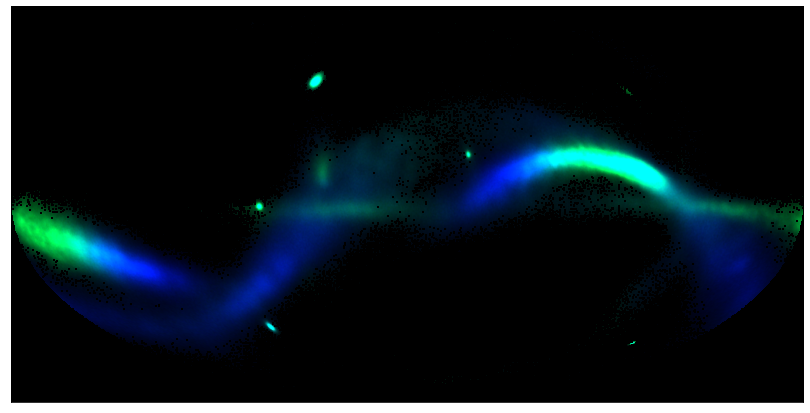

In [32]:
proj = hp.projector.MollweideProj() 
# proj = plot_density_healpy.get_ortho_proj(ends=[[20,-35],[15,-35]], half_sky=False)
# proj = hp.projector.MollweideProj(xsize=1024,rot=[266.4, -28.9, 59.])
# proj = hp.projector.MollweideProj(rot=rots['sag']) 
proj = hp.projector.MollweideProj(rot=[0, 45, 0], xsize=1024)
# proj = plot_density_healpy.get_ortho_proj(ends=[[5,-5],[15,-5]], half_sky=False)
# proj = hp.projector.OrthographicProj(xsize=1024, rot=[0, 0, 0])

nside = hp.get_nside(hpxcube[:,0])
func = lambda x, y, z: hp.vec2pix(nside, x, y, z)
img = np.stack([proj.projmap(rgb[i].filled(), func) for i in range(3)], axis=-1)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(img, origin='lower', extent=proj.get_extent())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()


In [110]:
mod = 17
mod_idx = np.argmin(np.abs(mod - moduli_des))

In [111]:
# COMBINE DATA
def combine_hpxcube(hpxcube1, hpxcube2, fracdet1, fracdet2, moduli1, moduli2):
    hpxcube, fracdet, moduli = np.copy(hpxcube1), np.copy(fracdet1), np.copy(moduli1)
    fracdet[hpxcube2[:,0] > 1] = 1.
    for mod in moduli2:
        mod_idx1 = np.argmin(np.abs(mod - moduli1))
        mod_idx2 = np.argmin(np.abs(mod - moduli2))
        hpxcube[:, mod_idx1] += hpxcube2[:, mod_idx2]
    return hpxcube, fracdet, moduli

In [112]:
reload(plot_density_healpy)
def plot_hpxcube(hpxcube, moduli, mod, proj='moll', q=[1, 95], vmin=None, vmax=None):
    if proj == 'moll':
        proj1 = plot_density_healpy.get_mollweide_proj()

    mod_idx = np.argmin(np.abs(mod - moduli))
    ax1, im1 = plot_density_healpy.plot_proj(proj1, hp.smoothing(hpxcube[:,mod_idx], sigma=np.radians(0.2)), q=q, vmin=vmin, vmax=vmax)
    ax1.set_title(r'$m - M = %.1f$' %mod)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

def plot_hpxmap(hpxmap, proj='moll', q=[1, 95], vmin=None, vmax=None, sigma=None, **kwargs):
    if proj == 'moll':
        proj1 = plot_density_healpy.get_mollweide_proj()

    if sigma is not None:
        hpxmap = hp.smoothing(hpxmap, sigma=np.radians(sigma))
    ax1, im1 = plot_density_healpy.plot_proj(proj1, hpxmap, q=q, vmin=vmin, vmax=vmax, **kwargs)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

def mask_hpxmap(hpxmap, mask_sel, fill_val=0.):
    mask = np.zeros_like(hpxmap)
    mask[mask_sel] = 1
    hpxmap = np.ma.array(hpxmap, mask=mask)
    hpxmap.fill_value = fill_val
    return hpxmap

def plot_surface_brightness(hpxmap, sb_limit=1000, vmin=None, vmax=None, savefile='surface_brightness.png'):
    hpxmap = np.copy(hpxmap)
    hpxmap[hpxmap == 0] = 1000
    if np.any([vmin==None, vmax==None]):
        vmin, vmax = np.min(hpxmap[hpxmap < 1000]), np.max(hpxmap[hpxmap < 1000])
    hpxmap[hpxmap > sb_limit] = 1000
    plot_hpxmap(hpxmap, vmin=vmin, vmax=vmax, cmap='Greys_r')
    plt.title(r'$\mu_{\rm V} < %i$' %sb_limit)
    plt.savefig('../plots/fire_mocks/%s' %savefile, facecolor="w")

In [123]:
import glob

halo = 'm12i_res7100'
fnames = glob.glob('../data/fire_mocks/hpxmaps/hpxmap_%s*.npy' %halo)
hpxmaps = []
for f in fnames:
    hpxmap = np.load(f)
    hpxmap[hpxmap == 0] = np.nan
    hpxmaps.append(hpxmap)

In [130]:
np.sum(~np.isnan(hpxmaps[4]))

48777

2.0


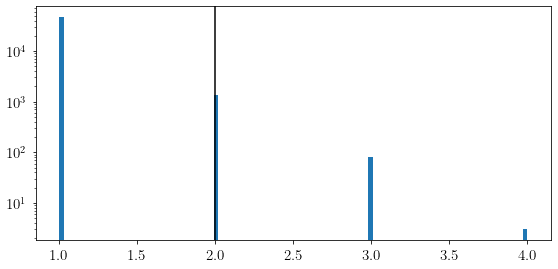

In [133]:
hpxmap = np.copy(hpxmaps[4])
hpxmap[hpxmap == 0] = np.nan

plt.figure(figsize=(8,4))
plt.hist(hpxmap, bins=100)

p90 = np.nanpercentile(hpxmap, 99.0)
plt.axvline(p90, c='k')
print(p90)
plt.yscale('log')
plt.show()

# hpxmap2 = np.copy(hpxmap)
# hpxmap2[hpxmap < 100] = np.nan
# print(np.nanmax(hpxmap2))

hpxmap_mask = np.zeros_like(hpxmap)
hpxmap_mask[hpxmap > p90] = 1.0

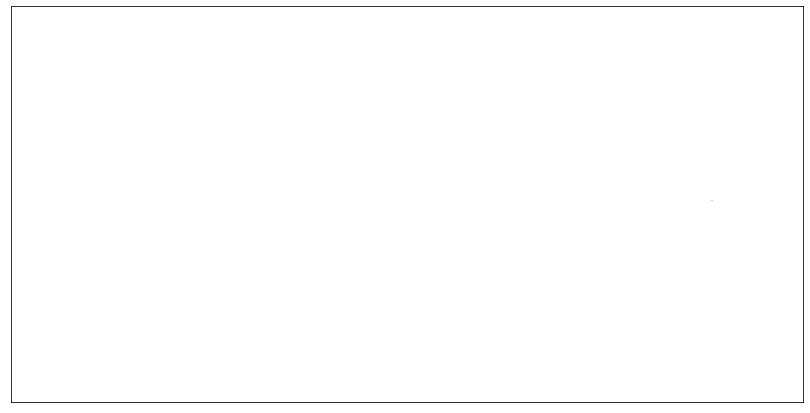

In [141]:
plot_hpxmap(hpxmap, vmin=0, vmax=4)

In [11]:
# hp.nside2npix(16)
# hpxmap16 = np.load('../data/fire_mocks/test_hpxmap_16_m12i.npy')
# proj1 = plot_density_healpy.get_mollweide_proj()
# q = [5,90]
# ax1, im1 = plot_density_healpy.plot_proj(proj1, hp.smoothing(hpxmap16, sigma=np.radians(0.2)), q=q)

In [113]:
import results
import rotation_matrix
import ugali.utils.healpix as uhp
import healpy

def get_rotmat(lon1, lat1, lon2, lat2, center=None):
    phi, theta, psi = results.euler_angles(lon1, lat1, lon2, lat2, center)
    R = results.create_matrix(phi, theta, psi)
    return R


lon1, lat1, lon2, lat2 = [10, 10, -10, -10]
ends = [lon1, lat1, lon2, lat2]
# nside = 512

def transform_hpxmap(hpxmap, ends):
    nside = hp.get_nside(hpxmap)
    lon1, lat1, lon2, lat2 = ends
    ra, dec = uhp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    R = get_rotmat(lon1, lat1, lon2, lat2)
    phi1, phi2 = rotation_matrix.phi12_rotmat(ra, dec, R)
    stream_pix = uhp.ang2pix(nside, phi1, phi2)
    hpx_stream = hpxmap[stream_pix]
    return hpx_stream

In [114]:
ends = [216.7, 32, 192.5, -8]
hpx_stream = transform_hpxmap(hpxcube_fire[:,0], ends)

2.2155157218817227e-08 2.0585021350247072


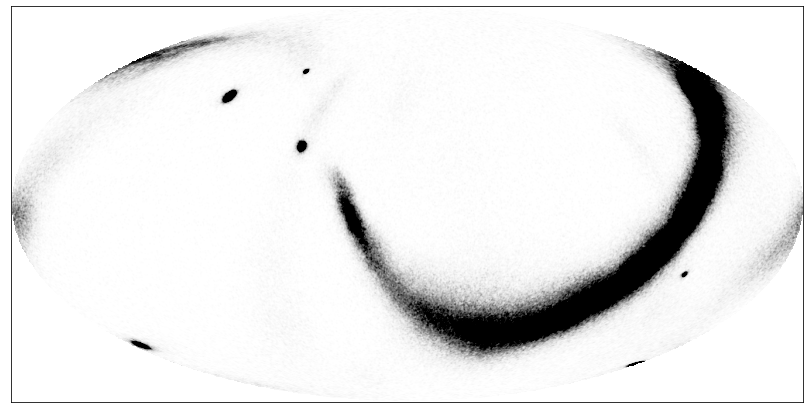

In [14]:
plot_hpxmap(hpx_stream, sigma=0.2)

In [95]:
plot_hpxcube(hpxcube_fire, moduli_fire, 17, q=[1,97])

Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
1.0545214679746894e-07 3.0356010772356683


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [96]:
plot_hpxcube(hpxcube_des, moduli_des, 17, q=[1,97])
# plot_hpxcube(hpxcube_des, moduli_des, 18, q=[1,97])
# plot_hpxcube(hpxcube_des, moduli_des, 19, q=[1,97])

Sigma is 12.000000 arcmin (0.003491 rad) 
-> fwhm is 28.257841 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
2.7750496789380464e-10 9.34557773657866


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

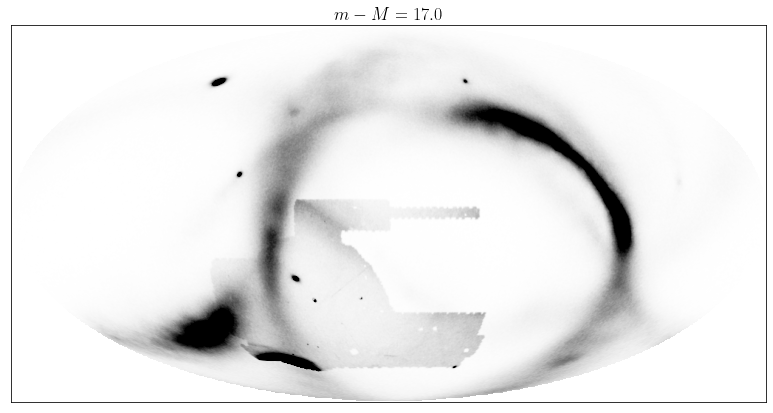

In [118]:
hpxcube, fracdet, moduli = combine_hpxcube(hpxcube_des, hpxcube_fire, fracdet_des, fracdet_fire, moduli_des, moduli_fire)
# plot_hpxcube(hpxcube, moduli, 17, vmin=2.7750496789380464e-10, vmax=9.34557773657866)
plot_hpxcube(hpxcube, moduli, 17, vmin=0, vmax=40)
plt.savefig('../plots/fire_mocks/des_m12i.png', bbox_inches='tight', facecolor='w')
# plot_hpxcube(hpxcube, moduli, 18)
# plot_hpxcube(hpxcube, moduli, 19)

In [33]:
# hpxcube, fracdet, moduli = combine_hpxcube(hpxcube_des, hpxcube_fire1, fracdet_des, fracdet_fire1, moduli_des, moduli_fire1)
# plot_hpxcube(hpxcube, moduli, 17)
# # plot_hpxcube(hpxcube, moduli, 18)
# # plot_hpxcube(hpxcube, moduli, 19)

In [34]:
# hpxcube, fracdet, moduli = combine_hpxcube(hpxcube_des, hpxcube_fire2, fracdet_des, fracdet_fire2, moduli_des, moduli_fire2)
# plot_hpxcube(hpxcube, moduli, 17)
# # plot_hpxcube(hpxcube, moduli, 18)
# # plot_hpxcube(hpxcube, moduli, 19)

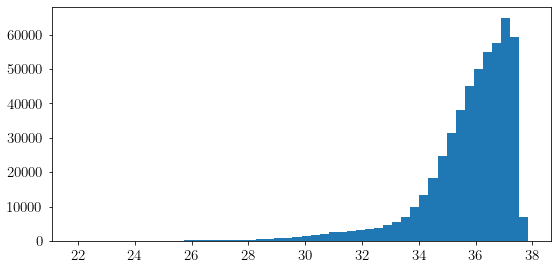

In [54]:
plt.figure(figsize=(8,4))
plt.hist(hpxmap_sb[hpxmap_sb > 0], bins=50)
plt.show()

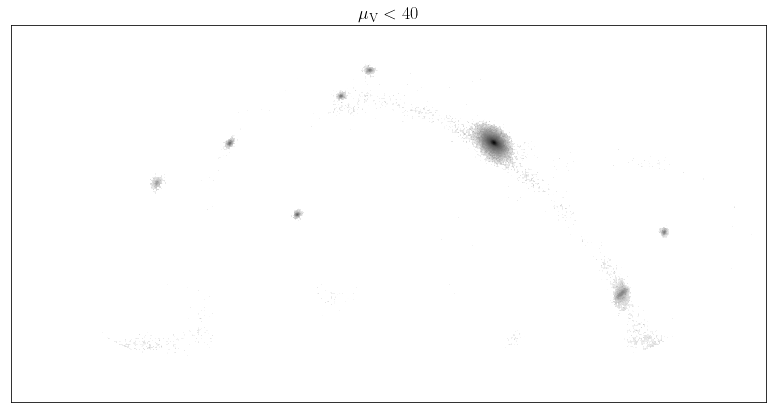

In [74]:
plot_surface_brightness(hpxmap_sb, sb_limit=sb_limit)

In [60]:
for lsr in [0, 1, 2, 3]:
    for halo in ['m12b', 'm12c', 'm12f', 'm12i', 'm12m', 'm12r', 'm12w', 'TL_host', 'TL_host2', 'RJ_host', 'RJ_host2']: # , 'RR_host', 'RR_host2']:
        if os.path.exists('../plots/fire_mocks/surface_brightness_%s_lsr%i_%i.png' %(halo, lsr, 40)):
            continue
        if not os.path.exists('../data/fire_mocks/stream_surface_brightness/%s_lsr%i_16.txt' %(halo, lsr)):
            continue
        hpxmap_sb = np.loadtxt('../data/fire_mocks/stream_surface_brightness/%s_lsr%i_16.txt'%(halo, lsr))
        for sb_limit in np.arange(28, 40+1):
            plot_surface_brightness(hpxmap_sb, sb_limit=sb_limit, savefile='surface_brightness_%s_lsr%i_%i.png' %(halo, lsr, sb_limit))

In [119]:
hpxmap_sb = np.loadtxt('../data/fire_mocks/stream_surface_brightness/m12i_lsr0_16.txt')

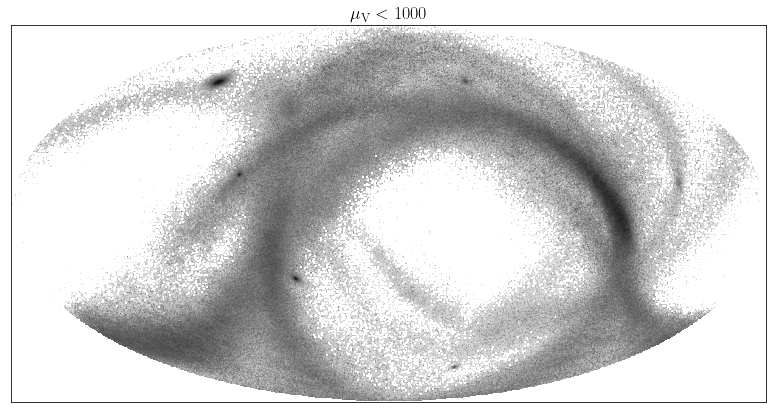

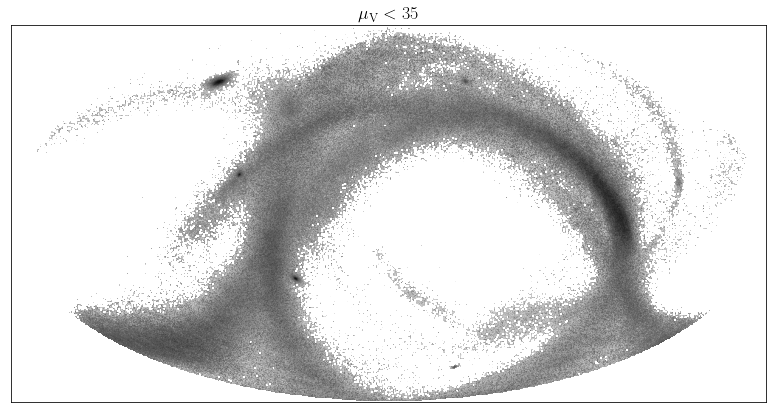

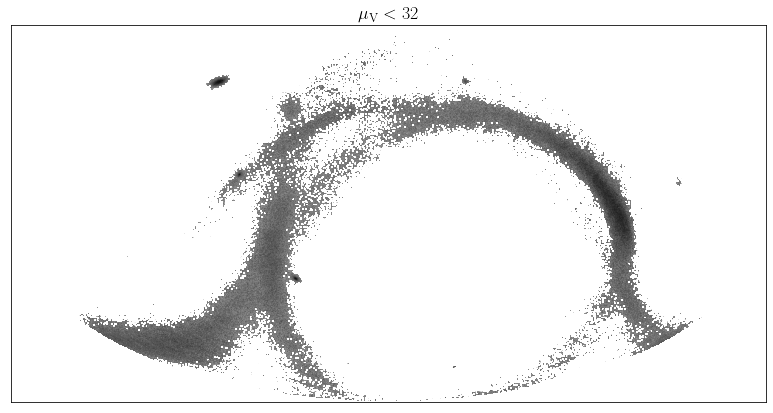

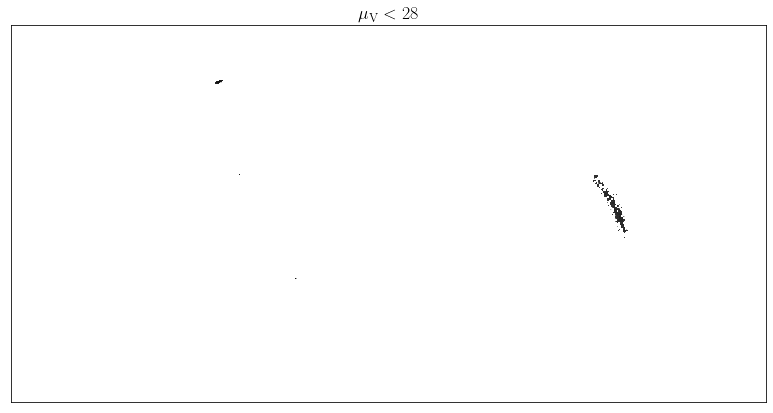

In [120]:
plot_surface_brightness(hpxmap_sb)
plot_surface_brightness(hpxmap_sb, sb_limit=35)
plot_surface_brightness(hpxmap_sb, sb_limit=32)
plot_surface_brightness(hpxmap_sb, sb_limit=28)

In [150]:
def plot_hpxcube(hpxcube, moduli, fracdet, mask_hpxcube=None, mu=17, bkg_sub=False, unmask=False):
    import plot_density_healpy
    reload(plot_density_healpy)
    import load_data
    reload(load_data)
    import streamlib
    reload(streamlib)
    import healpy as hp
    from matplotlib.path import Path
    plot_density_healpy.plot_pretty(fontsize=20)

    # proj1 = plot_density_healpy.get_ortho_proj(ends=[[25, -30],[30, -30]], half_sky=True)
    proj1 = plot_density_healpy.get_mollweide_proj()

    data = plot_density_healpy.prepare_data(mu, hpxcube, moduli, fracdet, sigma=0.2, fracmin=0.5, clip=100, lmc=True, milky_way=True, sgr=True, acs=False, globs_dwarfs=True, fill=False)
    data_unm = plot_density_healpy.prepare_data(mu, hpxcube, moduli, fracdet, sigma=0.2, fracmin=0.5, clip=100, all_off=True, fill=False)
    if bkg_sub:
        bkg1 = plot_density_healpy.fit_bkg(data, proj1, sigma=0.1)
        bkg1.mask = data_unm.mask

    if mask_hpxcube is not None:
        mask = data.mask
        mask[mask_hpxcube[:,0] > 0] = False
        data = np.ma.array(data, mask=mask)
        data.fill_value = np.ma.median(data)
        print(np.min(data[mask_hpxcube[:,0] > 0]), np.max(data[mask_hpxcube[:,0] > 0]), np.median(data[mask_hpxcube[:,0] > 0]))

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    if bkg_sub:
        ax1, im1 = plot_density_healpy.plot_proj(proj1, data - bkg1, vmin=-2, vmax=2, ax=ax)
    elif unmask:
        ax1, im1 = plot_density_healpy.plot_proj(proj1, data_unm, vmin=-1, vmax=12, ax=ax)
    else:
        ax1, im1 = plot_density_healpy.plot_proj(proj1, data, vmin=-1, vmax=12, ax=ax)
    ax1.set_title(r'$m - M = %.1f$' %mu)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)


In [ ]:
# def plot_combined_hpxcube(hpxcube1, hpxcube2, moduli1, moduli2, fracdet1, fracdet2, mu=17, bkg_sub=False):
#     import plot_density_healpy
#     reload(plot_density_healpy)
#     import load_data
#     reload(load_data)
#     import streamlib
#     reload(streamlib)
#     import healpy as hp
#     from matplotlib.path import Path
#     plot_density_healpy.plot_pretty(fontsize=20)

#     # proj1 = plot_density_healpy.get_ortho_proj(ends=[[25, -30],[30, -30]], half_sky=True)
#     proj1 = plot_density_healpy.get_mollweide_proj()

#     data1 = plot_density_healpy.prepare_data(mu, hpxcube1, moduli1, fracdet1, sigma=0.2, fracmin=0.5, clip=100, lmc=True, milky_way=True, sgr=True, acs=False, globs_dwarfs=True)
#     data2 = plot_density_healpy.prepare_data(mu, hpxcube2, moduli2, fracdet2, sigma=0.2, fracmin=0.5, clip=100, lmc=True, milky_way=True, sgr=True, acs=False, globs_dwarfs=True)

# #     if bkg_sub:
# #         data_unm = plot_density_healpy.prepare_data(mu, hpxcube, moduli, fracdet, sigma=0.2, fracmin=0.5, clip=100, all_off=True)
# #         bkg1 = plot_density_healpy.fit_bkg(data, proj1, sigma=0.1)
# #         bkg1.mask = data_unm.mask

#     mask = data1.mask
#     mask[hpxcube2[:,0] > 0] = False
#     data = np.ma.array(data, mask=mask)

#     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#     if bkg_sub:
#         ax1, im1 = plot_density_healpy.plot_proj(proj1, data - bkg1, vmin=-2, vmax=2, ax=ax)
#     else:
#         ax1, im1 = plot_density_healpy.plot_proj(proj1, data, vmin=-1, vmax=12, ax=ax)
#     ax1.set_title(r'$m - M = %.1f$' %mu)
#     ax1.get_xaxis().set_visible(False)
#     ax1.get_yaxis().set_visible(False)


17.0


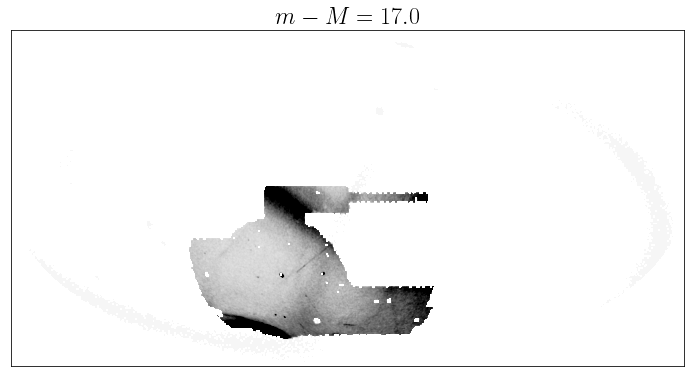

In [109]:
# import plot_density_healpy
# reload(plot_density_healpy)
# import load_data
# reload(load_data)
# import streamlib
# reload(streamlib)
# import healpy as hp
# from matplotlib.path import Path
# plot_density_healpy.plot_pretty(fontsize=20)

# # proj1 = plot_density_healpy.get_ortho_proj(ends=[[25, -30],[30, -30]], half_sky=True)
# proj1 = plot_density_healpy.get_mollweide_proj()

# # mu = 16.8
# # for mu in modulus:
# for mu in [17.0]:
#     print(mu)

# #     data = plot_density_healpy.prepare_data(mu, hpxcube_fire, np.array([17]), fracdet, sigma=0.2, fracmin=0.5, clip=100, sgr=True, acs=False, globs_dwarfs=True)
#     data = plot_density_healpy.prepare_data(mu, hpxcube, moduli, fracdet, sigma=0.2, fracmin=0.5, clip=100, lmc=True, milky_way=True, sgr=True, acs=False, globs_dwarfs=True)
#     if bkg_sub:
#         data_unm = plot_density_healpy.prepare_data(mu, hpxcube, moduli, fracdet, sigma=0.2, fracmin=0.5, clip=100, lmc=False, milky_way=False, sgr=False, globulars=False, dwarfs=False, galaxies=False, plane=False, center=False, globs_dwarfs=False, acs=False)
#         bkg1 = plot_density_healpy.fit_bkg(data, proj1, sigma=0.1)
#         bkg1.mask = data_unm.mask
    
# #     fire_outside_des = hpxcube_fire[:,0] # temp
# #     data[fracdet == 0] += fire_outside_des[fracdet == 0]
# #     data.mask[hpxcube_fire[:,0] > 0] = np.ma.nomask

#     fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#     if bkg_sub:
#         ax1, im1 = plot_density_healpy.plot_proj(proj1, data - bkg1, vmin=-2, vmax=2, ax=ax)
#     ax1, im1 = plot_density_healpy.plot_proj(proj1, data, vmin=-1, vmax=12, ax=ax)
#     ax1.set_title(r'$m - M = %.1f$' %mu)
#     ax1.get_xaxis().set_visible(False)
#     ax1.get_yaxis().set_visible(False)


-0.03004476230970976 958.1698129945675 5.721530138558251e-09


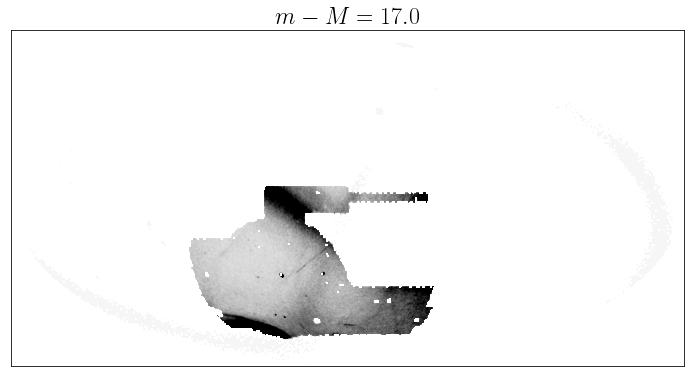

In [151]:
plot_hpxcube(hpxcube, moduli, fracdet_des, mask_hpxcube=hpxcube_fire, mu=17)

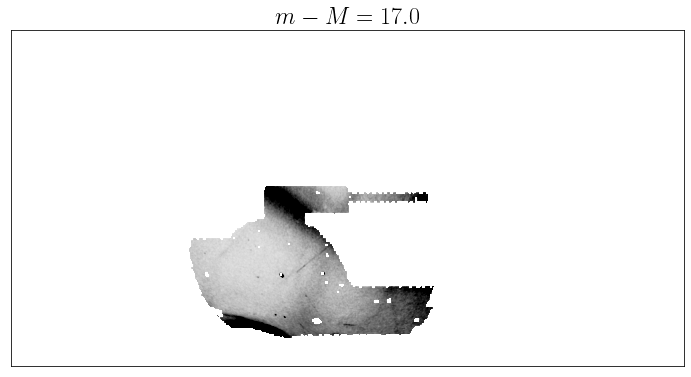

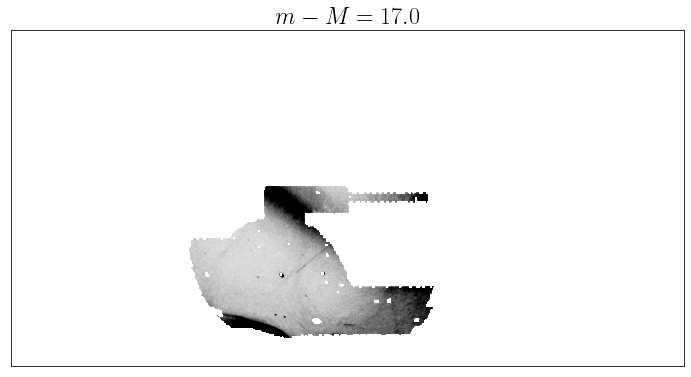

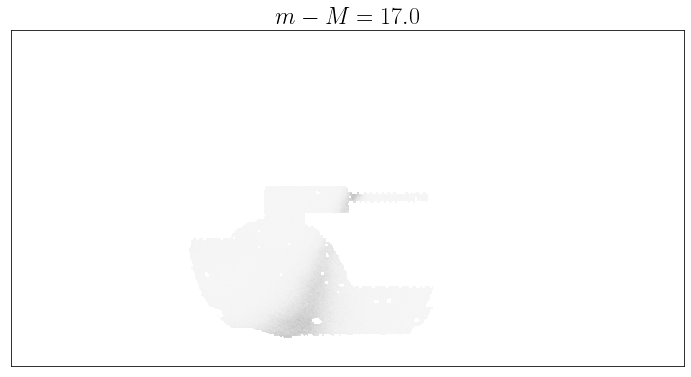

In [133]:
# plot_hpxcube(hpxcube, moduli, 17)
plot_hpxcube(hpxcube_des, moduli, 17)
# plot_hpxcube(hpxcube_fire, moduli_fire, 17, unmask=True)


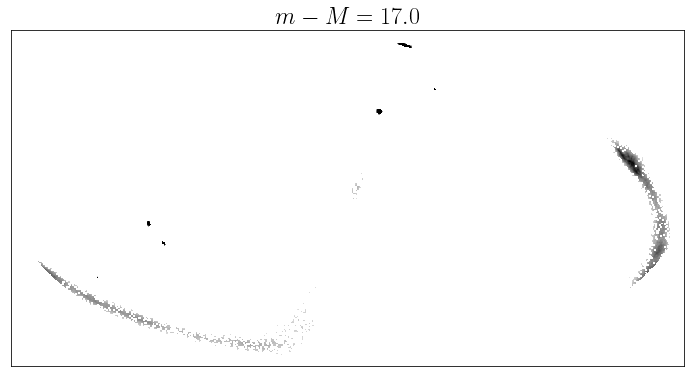

In [141]:
plot_hpxcube(hpxcube_fire, moduli_fire, fracdet_fire, 17, unmask=False)

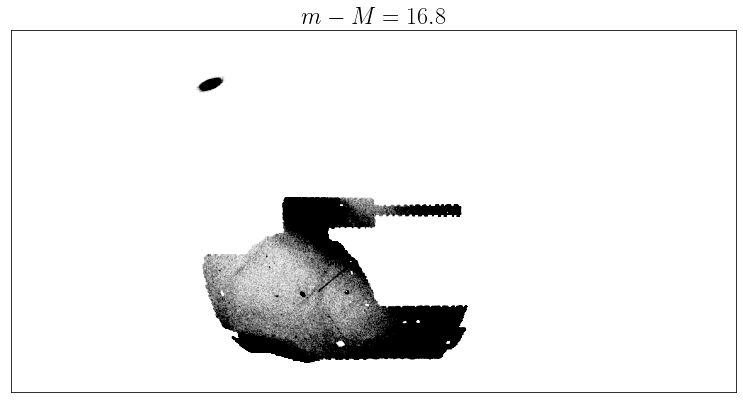

In [104]:
proj1 = plot_density_healpy.get_mollweide_proj()
data = hpxcube[:,fire_mod_idx]
data = hp.smoothing(data, sigma=np.radians(0.1), verbose=False)
ax1, im1 = plot_density_healpy.plot_proj(proj1, data, vmin=1, vmax=5)
ax1.set_title(r'$m - M = %.1f$' %mu)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
